# Initialization



In [1]:
import sys
sys.path.append("./python_files")
LOG_DIR = './log'

In [95]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_models import *
from loss import *
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
torch.__version__

'0.4.1'

In [4]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=True)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [8]:
train_input = train_input.narrow(0, 0, 5000)
train_target = train_target.narrow(0, 0, 5000)

5


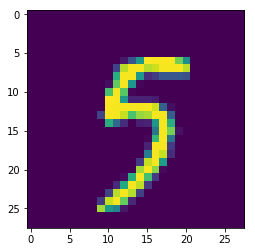

In [9]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet F

In [6]:
load_from_memory = False

In [ ]:
#debug_layers_dims(shadow_model(vector_dimension), vector_dimension)

In [ ]:
#debug_layers_dims(LeNet(), train_input.shape)

In [5]:
computeClassesWeights(train_target)

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

In [13]:
train_dataset = (train_input.narrow(0, 0, 5000), train_target.narrow(0, 0, 5000))
test_dataset = (test_input.narrow(0, 0, 5000), test_target.narrow(0, 0, 5000))

In [14]:
if not load_from_memory:
    shadow_models = list()
    nb_shadow_models = 10

    (shadow_train_datasets, shadow_test_datasets) = \
        generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)

    for i in range(nb_shadow_models):
        print("training model", i)
        shadow_models.append(LeoNet())

        crit_fun = lambda input_, target : (input_, target)
        y_hat_fun = lambda y: y.argmax(1)

        loss_fun = nn.CrossEntropyLoss()
        learning_rate = 0.1

        mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
        hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=300, batch_size=500, verbose=0)
        #mt.plot_training("Learning curves")

training model 0
training model 1
training model 2
training model 3
training model 4
training model 5
training model 6
training model 7
training model 8
training model 9


In [16]:
if not load_from_memory:
    for i in range(nb_shadow_models):
        save_model_state(shadow_models[i], 'shadow_models/shadow_model_'+str(i)+'_F.pickle')

In [ ]:
if load_from_memory:
        
    shadow_models = list()
    nb_shadow_models = 100

    (shadow_train_datasets, shadow_test_datasets) = \
        generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)
    
    for i in range(nb_shadow_models):
        shadow_models.append(LeoNet())
        
    for i in range(nb_shadow_models):
        load_model_state(shadow_models[i], 'shadow_models/shadow_model_'+str(i)+'_F.pickle')

## G leonet

In [105]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()
    
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i].conv1)
    layer_names.append("shadow_model["+str(i)+"].conv")

In [106]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [107]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [108]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)
flattened_size = np.prod(np.array(g_shadow_train_dataset[0].shape[1:]))
print("size of flattened input (1 sample):", flattened_size)

size of layer vector : torch.Size([741, 1, 16, 24, 24])
size of flattened input (1 sample): 9216


In [109]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.5101, 0.4899])

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.69536191           0.493      0.69610202           0.500
25                   0.66617310           0.600      0.69337982           0.500
50                   0.62550473           0.703      0.66333586           0.591
75                   0.57454056           0.777      0.63935202           0.640
100                  0.51007795           0.852      0.64864272           0.610
125                  0.47612190           0.869      0.64941007           0.631
150                  0.43954945           0.899      0.67522615           0.595
175                  0.40810007           0.931      0.66658545           0.627
200                  0.39214116           0.933      0.67287439           0.622
225                  0.37308794           0.961      0.66876376           0.621
250                  0.35902482         

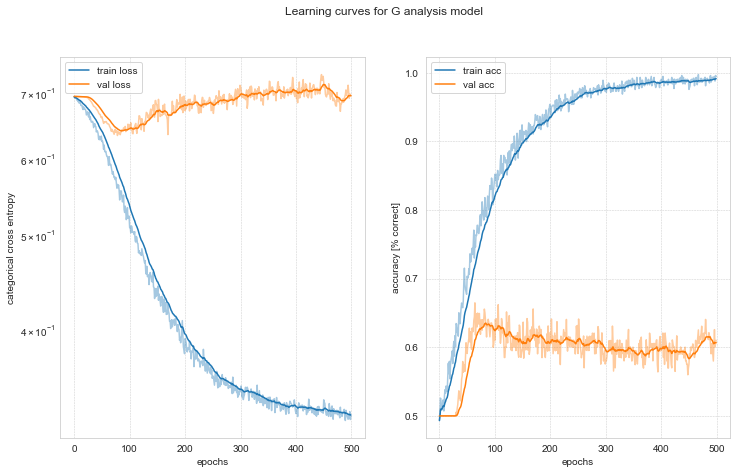

In [111]:
shadow_modelG = denseG(flattened_size)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss()
learning_rate = 0.05
epochs = 500

batch_size = 1000
batch_cap = 1000
batch_fun = lambda x, y: x * (y // batch_cap + 1)

mt = ModelTrainer(shadow_modelG, loss_fun, optim.SGD(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=batch_size, verbose=epochs/20)
mt.plot_training("Learning curves for G analysis model")

false negative percentage : 34.65346534653466
false positive percentage : 43.29896907216495


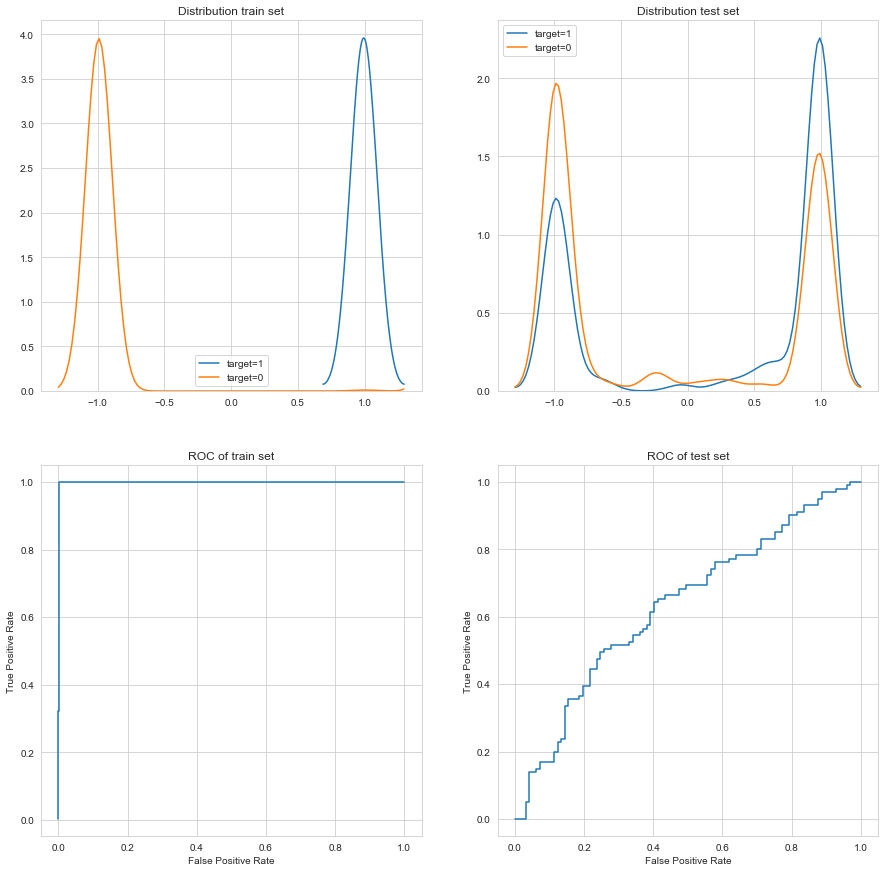

In [112]:
diagnostic_plots(shadow_modelG, g_shadow_train_dataset, g_shadow_test_dataset)

### Not leonet

In [11]:
train_dataset = (train_input.narrow(0, 0, 5000), train_target.narrow(0, 0, 5000))
test_dataset = (test_input.narrow(0, 0, 5000), test_target.narrow(0, 0, 5000))

in_channels = train_input.shape[1]
out_channels = 10

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    2.03629406           0.277      1.71550798           0.424
10                   0.16437001           0.951      0.20930730           0.933
20                   0.07026370           0.979      0.18079254           0.942
30                   0.05014570           0.985      0.19545080           0.943
40                   0.04118915           0.988      0.19600201           0.944
49                   0.03099532           0.992      0.21070847           0.942
*******************************************************************************


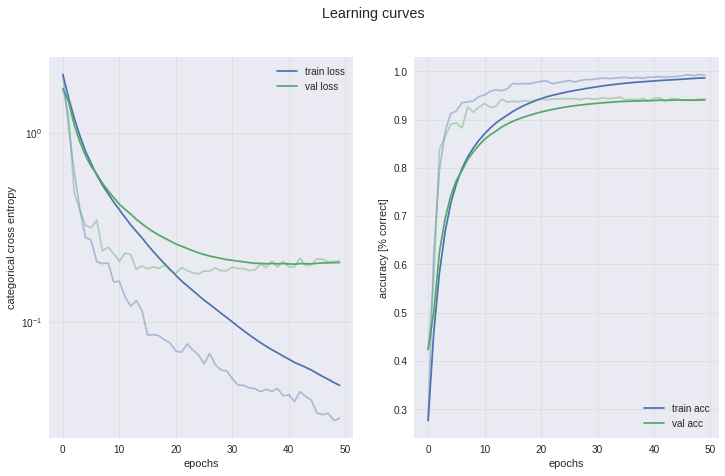

In [14]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 15
batch_fun = lambda x, y: x * (y // batch_cap + 1)
vector_dimension = train_dataset[0].shape

net = LeoNet()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

batch_size = 100

dataset = 'MNIST'
tsx_name = LOG_DIR + '/{}_lr_{},batchSize_{}'.format(dataset, learning_rate, batch_size)

mt = ModelTrainer(net, loss_fun, optim.SGD(net.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun, tsx_name)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=batch_size, verbose=10)
mt.plot_training("Learning curves")

##1.2) 10F


training shadow model [0] ...done !
training shadow model [1] ...done !
training shadow model [2] ...done !
training shadow model [3] ...done !
training shadow model [4] ...done !


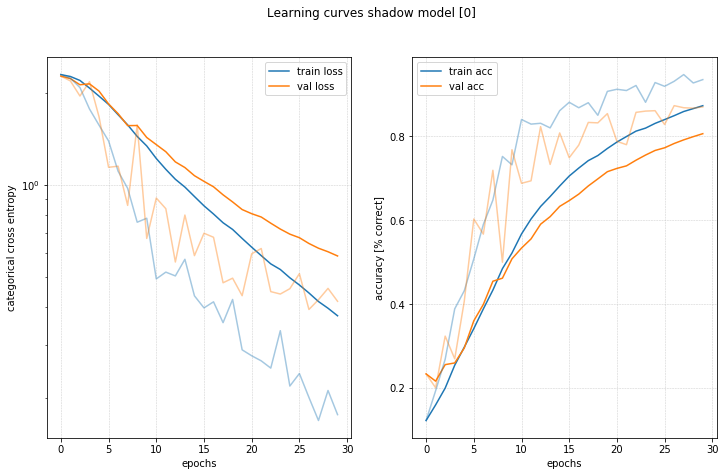

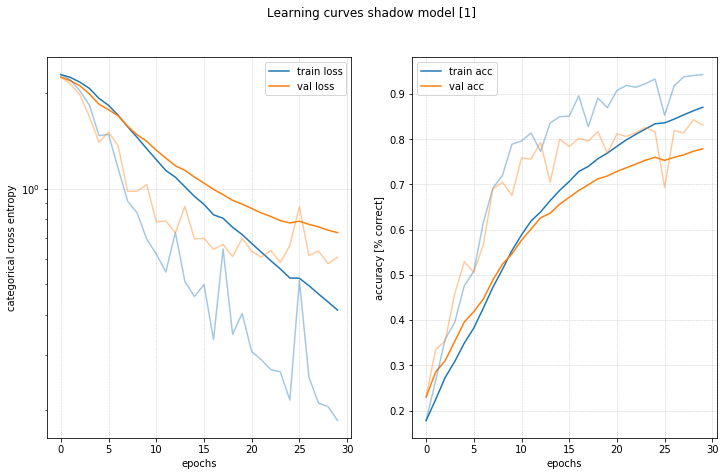

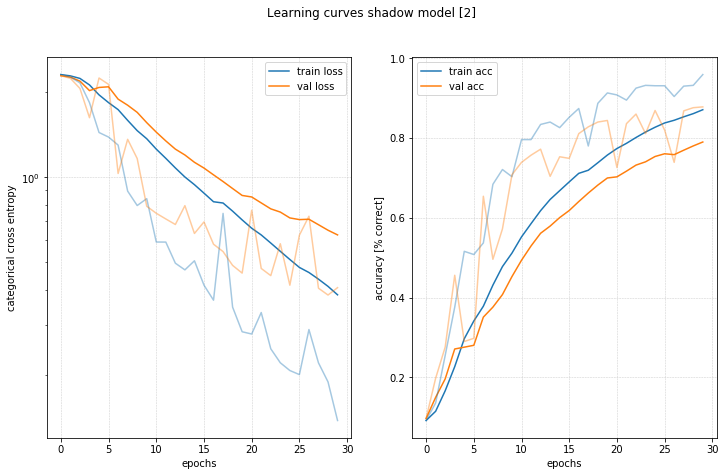

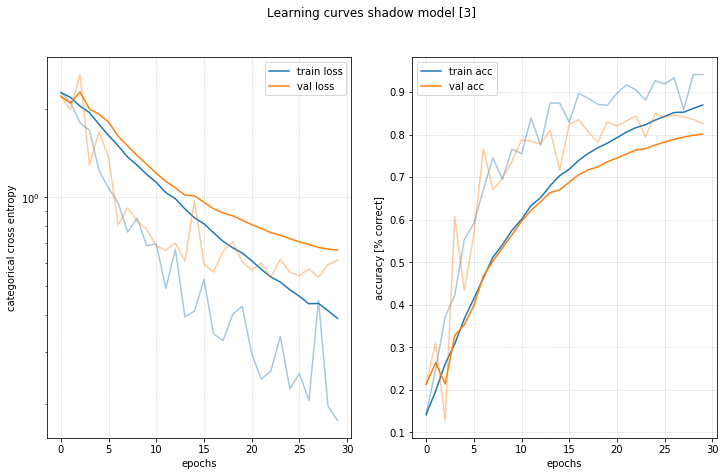

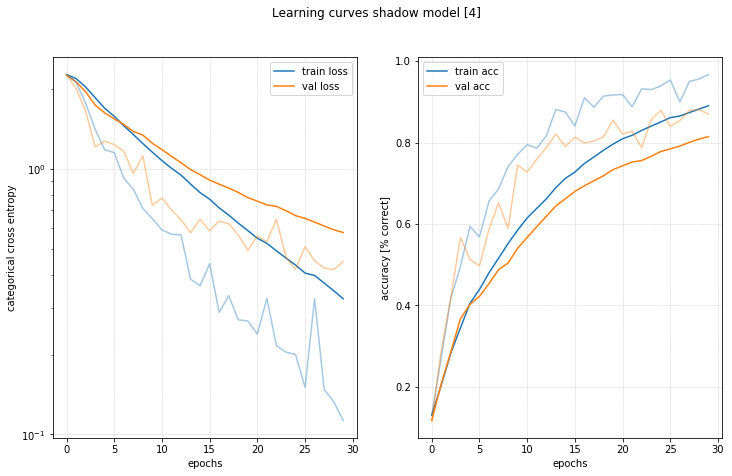

In [14]:
nb_models = 5
(shadow_train_datasets, shadow_test_datasets) = generate_n_shadow_models_datasets(nb_models, train_dataset, test_dataset)

#Define training parameters
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
learning_rate = 0.1
nb_epochs = 30
batch_size = 100
dataset = 'MNIST'
verbose = 0
batch_cap = 50
batch_fun = lambda x, y: x * (y // batch_cap + 1)
vector_dimension = shadow_train_datasets[0][0].shape

#create the shadow models
model_class = LeoNet
shadow_models = list()
for i in range(nb_models):
    shadow_models.append(model_class())
    
#train the shadow models
for i in range(nb_models):
    print("training shadow model ["+str(i)+"] ...", end='')
    tsx_name = None#LOG_DIR + '/{}/F/LeoNet[{}]_lr_{},batchSize_{}'.format(dataset, i, learning_rate, batch_size)

    crossEntropyClassesWeigths = computeClassesWeights(shadow_train_datasets[i][1])

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)

    mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun, tsx_name = tsx_name)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=nb_epochs, batch_size=batch_size, verbose=verbose)
    mt.plot_training("Learning curves shadow model ["+str(i)+"]")
    print("done !")


## 2) Net G

## Net def

In [109]:
32 * 6 * 6

1152

In [15]:
def kindaResnetG(layer_dim):
    dim = layer_dim[2]
    pad = (1, 1, 1)
    pool = 2
    finalVectorSize = (layer_dim[2]//pool) * (layer_dim[3]//pool) * (layer_dim[4]//pool)
    model = nn.Sequential(
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.MaxPool3d(pool),
      
      View([-1]),
      nn.Linear(finalVectorSize, 64),
      nn.ELU(),
      nn.Dropout3d(),
      #nn.Linear(64, 128),
      #nn.ReLU(),
      #nn.Linear(512, 128),
      #nn.ELU(),
      nn.Dropout3d(),
      nn.Linear(64, 64),
      nn.ELU(),
      nn.Dropout3d(0.8),
      nn.Linear(64, 2),
      
    )
    return model

def ResnetG(layer_dim): # ba:50 ,bs:100
    dim = layer_dim[2]
    pad = (1, 1, 1)
    pool = 2
    finalVectorSize = (layer_dim[2]//pool) * (layer_dim[3]//pool) * (layer_dim[4]//pool)
    model = nn.Sequential(
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.BatchNorm3d(1),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.Dropout3d(),
      nn.Conv3d(1, 1, kernel_size=3, padding = pad),
      nn.ELU(),
      nn.MaxPool3d(pool),
      
      View([-1]),
      nn.Linear(finalVectorSize, 64),
      nn.ELU(),
      nn.Linear(64, 128),
      nn.ELU(),
      nn.Linear(128, 128),
      nn.ELU(),
      nn.Linear(128, 2),
      
    )
    return model

def aliGs(vector_size):
    finalVectorSize = (((((vector_size-7)//2)-4)//2)-2)//2
    
    model = nn.Sequential(
        nn.Conv1d(1, 32, kernel_size = 8),
        nn.RReLU(),
        nn.BatchNorm1d(32),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(32, 64, kernel_size = 5),
        nn.RReLU(),
        nn.BatchNorm1d(64),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(64, 16, kernel_size = 3),
        nn.RReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size = 2),
        
        View([-1]),
        nn.Linear(16* finalVectorSize, 100),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(100, 32),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(32, 2)
    )
    
    return model
  
def daAliG(vector_size):
    finalVectorSize = (((((vector_size-7)//2)-4)//2)-2)//2
    
    model = nn.Sequential(
        nn.Conv1d(1, 256, kernel_size = 8, stride=1),
        nn.RReLU(),
        nn.BatchNorm1d(256),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(256, 128, kernel_size = 5),
        nn.RReLU(),
        nn.BatchNorm1d(128),
        nn.MaxPool1d(kernel_size = 2),
        
        nn.Conv1d(128, 16, kernel_size = 3),
        nn.RReLU(),
        nn.BatchNorm1d(16),
        nn.MaxPool1d(kernel_size = 2),
        
        View([-1]),
        nn.Linear(16* finalVectorSize, 128),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(128, 128),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(128, 32),
        nn.RReLU(),
        nn.Dropout(),
        
        nn.Linear(32, 2)
    )
    
    return model
  
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 128),
        nn.RReLU(),
        nn.Dropout(0.3),
        
        nn.Linear(128, 128),
        nn.RReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(128, 2),
    )
    return model

In [16]:
debug_layers_dims(ResnetG(g_train_dataset[0].shape), g_train_dataset[0].shape)

NameError: name 'g_train_dataset' is not defined

## Playground n=1

In [ ]:
label = 5
idx = train_dataset[1] == label
label_train_dataset = (train_dataset[0][idx], train_dataset[1][idx])
idx = test_dataset[1] == label
label_test_dataset = (test_dataset[0][idx], test_dataset[1][idx])

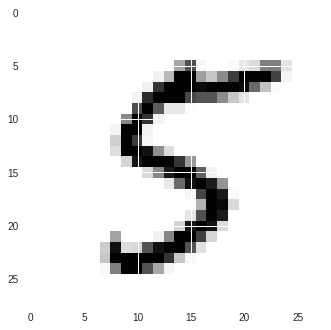

In [14]:
i = 10
plt.imshow(label_test_dataset[0][i, 0, :, :])

In [42]:
net0 = shadow_models[0]
net0

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25)
  (12): View(_, [-1])
  (13): Linear(in_features=1024, out_features=512, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5)
  (16): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
(g_train_input, g_train_target), (g_test_input, g_test_target) = \
generate_dataset_g(net, train_dataset, test_dataset, [net[8]], ['conv'], split=0.8, full=True)

g_train_target = g_train_target.long()
g_test_target = g_test_target.long()

g_train_dataset = (g_train_input, g_train_target)
g_test_dataset = (g_test_input, g_test_target)  

In [100]:
g_train_input.shape

torch.Size([8000, 1, 64, 13, 13])

In [101]:
size_input_vector = g_train_dataset[0].shape#[2]
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([8000, 1, 64, 13, 13])


In [102]:
g_train_dataset[1].shape[0]

8000

In [103]:
target_classes = np.array(g_train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 4000, 1: 4000}


In [114]:
modelG = kindaResnetG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 40
batch_fun = lambda x, y: x // (y // batch_cap + 1) #x: batch_size, y: epoch

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.01

mt = ModelTrainer(modelG, loss_fun, optim.Adagrad(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=100, batch_size=2000, verbose=10)
mt.plot_training("Learning curves for G analysis model")

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00086375           0.491      0.00038647           0.500
10                   0.00034675           0.519      0.00034668           0.504
20                   0.00034287           0.548      0.00034754           0.516
30                   0.00033972           0.566      0.00035122           0.520
40                   0.00067090           0.585      0.00035283           0.515
50                   0.00066165           0.602      0.00035828           0.503


KeyboardInterrupt: ignored

## Playground n = 10

In [17]:
def Gshadow(vector_dimension) :
    channels = vector_dimension[1]
    size = vector_dimension[2]
    linear_size = 7744#(((((size - 2) // 2) - 2) // 2) ** 2) * 64 

    model = nn.Sequential(
      View([-1]),
      nn.Linear(linear_size, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 2)
    )
    return model

In [ ]:
def generate_dataset_g_per_class_from_shadows(models, train_dataset, test_dataset, layers, layer_names, split=0.7, full=True):
    """
    Generate the dataset for g with the values spied from the given layers for each models as input and the
    labels taking value '1' if the original data was part of the train set, '0' otherwise. 
    The generated datasets are separated by classes, ie. if your original training/testing
    data had n target classes, this function will return two lists (train and test) of n 
    components, with the i-th component being the train or test dataset for the i-th 
    target class.
    Args:
    -models : Array containing the models to spy
    -train_dataset: original train dataset
    -test_dataset: original test dataset
    -layers: Array of array containing the model layers to spy on
    -layer_name: Array of array containing the names of the layer, to be used as keys in the returned
    -split: Percentage of data to keep for the new train dataset
    Returns:
    -list of n new train datasets
    -list of n new test dataset
    """
    train_input, train_target = train_dataset
    test_input, test_target = test_dataset
    
    target_classes = torch.unique(train_target, sorted=True)

    train_mask_classes = [train_target == c for c in target_classes]
    test_mask_classes = [test_target == c for c in target_classes]

    train_dataset_classes = [(train_input[mask], train_target[mask]) for mask in train_mask_classes]
    test_dataset_classes = [(test_input[mask], test_target[mask]) for mask in test_mask_classes]
    
    g_train_dataset_classes = list()
    g_test_dataset_classes = list()

    for c in target_classes:
        g_train_input_full = None
        g_train_target_full = None
        g_test_input_full = None
        g_test_target_full = None

        for i, net in enumerate(models):
            (g_train_input, g_train_target), (g_test_input, g_test_target) = \
            generate_dataset_g(net, train_dataset_classes[c], test_dataset_classes[c], layers[i], layer_names[i], split=split, full=full)

            g_train_target = g_train_target.long()
            g_test_target = g_test_target.long()

            if g_train_input_full is None:
                g_train_input_full = g_train_input
                g_train_target_full = g_train_target
                g_test_input_full = g_test_input
                g_test_target_full = g_test_target
            else:
                g_train_input_full = torch.cat((g_train_input_full,g_train_input), 0)
                g_train_target_full = torch.cat((g_train_target_full, g_train_target), 0)
                g_test_input_full = torch.cat((g_test_input_full, g_test_input), 0)
                g_test_target_full = torch.cat((g_test_target_full, g_test_target), 0)

        (tmp1, tmp2) = (g_train_input_full, g_train_target_full), (g_test_input_full, g_test_target_full)
            
        g_train_dataset_classes.append(tmp1)
        g_test_dataset_classes.append(tmp2)
        
    return g_train_dataset_classes, g_test_dataset_classes




In [21]:
layers = [[l.conv2] for l in shadow_models]
layer_names = ['conv2']
g_train_dataset_classes, g_test_dataset_classes = generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.7, full=True)

In [24]:
g_train_dataset_classes[0][1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

*************** Class 4 ********************
size of layer vector : torch.Size([720, 1, 4, 4, 4])
repartition of labels : {0: 348, 1: 372}
******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.69386620           0.508      0.69087648           0.517
10                   0.68928721           0.521      0.69134480           0.514
20                   0.69032935           0.519      0.69109780           0.517
30                   0.68898983           0.535      0.69098747           0.517
40                   0.68694440           0.543      0.69138247           0.511
50                   0.68475396           0.560      0.69126457           0.514
60                   0.68278141           0.565      0.69148147           0.540
70                   0.67915736           0.567      0.69173628           0.540
80                   0.68108325           0.557      0.691727

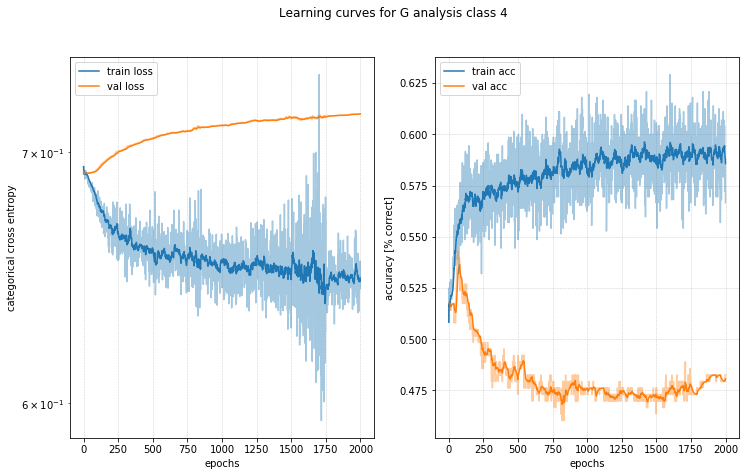

In [26]:
#for i in range(10):
i=4
g_train_dataset = g_train_dataset_classes[i]
g_test_dataset = g_test_dataset_classes[i]

size_input_vector = g_train_dataset[0].shape#[2]
print('*************** Class {} ********************'.format(i))
print("size of layer vector :", size_input_vector)

target_classes = np.array(g_train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print("repartition of labels :", dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

modelG = ResnetG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
batch_cap = 50
batch_fun = lambda x, y: x * (y // batch_cap + 1) #x: batch_size, y: epoch

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.001
batch_size = 20
tsx_name = None#LOG_DIR + '/{}/G/ResnetG[{}]_lr_{},batchSize_{},batchCap_{}'.format(dataset, i, learning_rate, batch_size, batch_cap)

mt = ModelTrainer(modelG, loss_fun, optim.Adagrad(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun, batch_fun, tsx_name, nb_labels=2)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=2000, batch_size=batch_size, verbose=10)
mt.plot_training("Learning curves for G analysis class {}".format(i))